## Notebook journey

`the notebook have all the ideas about how i think to made all of this and specially the markdown text i write after each step to evaluate my brain data solving read it carefully`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, RFE
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

In [2]:
np.random.seed(42)
plt.style.use('default')

## Loading Data 

In [3]:
train_data = pd.read_csv('../!0Withsecure/data/train_data.csv', header=None)
train_labels = pd.read_csv('../!0Withsecure/data/train_labels.csv', header=None).values.ravel()
test_data = pd.read_csv('../!0Withsecure/data/test_data.csv', header=None)

# print(train_data.head())
# print(train_labels.head())
# print(test_data.head())

In [4]:
print(f"Training data shape: {train_data.shape}")
print(f"Training labels shape: {train_labels.shape}")
print(f"Test data shape: {test_data.shape}")

Training data shape: (3750, 10000)
Training labels shape: (3750,)
Test data shape: (1250, 10000)


## Check class distribution in train labels data 

In [5]:
unique_labels = np.unique(train_labels)
unique_labels

array([-1,  1])

In [6]:
# get count of label -1 and 1
print(f"Count of label -1: {np.sum(train_labels == -1)}")

Count of label -1: 373


In [7]:
print(f"Count of label 1: {np.sum(train_labels == 1)}")

Count of label 1: 3377


In [8]:
class_counts = np.array([np.sum(train_labels == -1), np.sum(train_labels == 1)])
print(f"Class imbalance ratio: {class_counts[1]/class_counts[0]:.2f}:1")

Class imbalance ratio: 9.05:1


## Description - Statistics 

In [9]:
# Basic statistics
print(f"Mean feature variance: {train_data.var(axis=0).mean():.3f}")
print(f"Mean feature mean: {train_data.mean(axis=0).mean():.3f}")
print(f"Features with zero variance: {(train_data.var(axis=0) == 0).sum()}")
print(f"Features with very low variance (<0.01): {(train_data.var(axis=0) < 0.01).sum()}")


Mean feature variance: 3130424.963
Mean feature mean: 23.652
Features with zero variance: 0
Features with very low variance (<0.01): 0


In [10]:
print(f"Missing values in train_data: {train_data.isnull().sum().sum()}")
print(f"Missing values in test_data: {test_data.isnull().sum().sum()}")
print(f"Data types: {train_data.dtypes.unique()}")

Missing values in train_data: 0
Missing values in test_data: 0
Data types: [dtype('float64')]


In [11]:
print(f"Training data - Mean: {train_data.mean().mean():.3f}, Std: {train_data.std().mean():.3f}")
print(f"Test data - Mean: {test_data.mean().mean():.3f}, Std: {test_data.std().mean():.3f}")

Training data - Mean: 23.652, Std: 584.122
Test data - Mean: 22.117, Std: 584.220


In [12]:
train_var = train_data.var()
print(f"Features with zero variance: {(train_var == 0).sum()}")
print(f"Features with very low variance (<0.01): {(train_var < 0.01).sum()}")

Features with zero variance: 0
Features with very low variance (<0.01): 0


## Visualization

    - to understand more about the data 

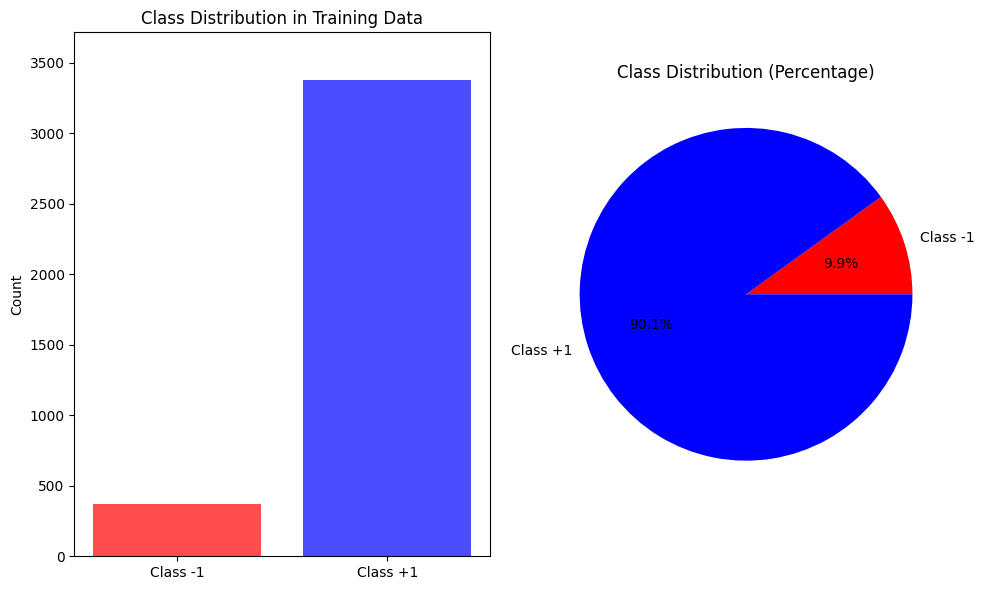

In [13]:
# Visualize class distribution
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.bar(['Class -1', 'Class +1'], [class_counts[0], class_counts[1]], 
        color=['red', 'blue'], alpha=0.7)
plt.title('Class Distribution in Training Data')
plt.ylabel('Count')
plt.ylim(0, max(class_counts) * 1.1)

plt.subplot(1, 2, 2)
plt.pie([class_counts[0], class_counts[1]], labels=['Class -1', 'Class +1'], 
        autopct='%1.1f%%', colors=['red', 'blue'])
plt.title('Class Distribution (Percentage)')

plt.tight_layout()
plt.savefig('screens/class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

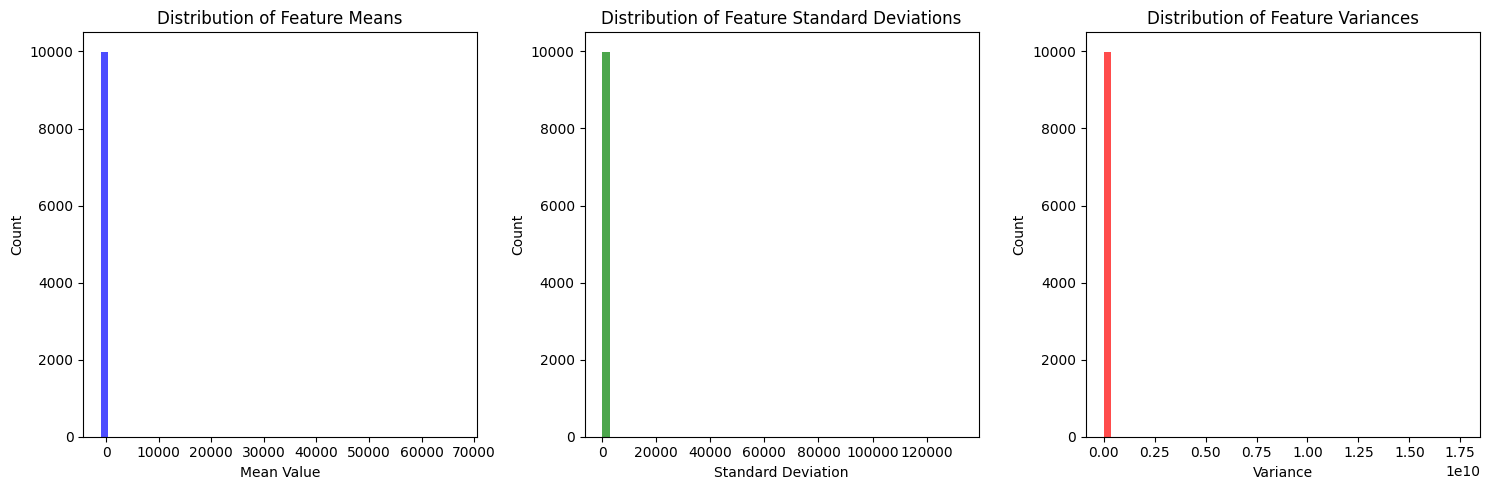

In [14]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.hist(train_data.mean(), bins=50, alpha=0.7, color='blue')
plt.title('Distribution of Feature Means')
plt.xlabel('Mean Value')
plt.ylabel('Count')

plt.subplot(1, 3, 2)
plt.hist(train_data.std(), bins=50, alpha=0.7, color='green')
plt.title('Distribution of Feature Standard Deviations')
plt.xlabel('Standard Deviation')
plt.ylabel('Count')

plt.subplot(1, 3, 3)
plt.hist(train_var, bins=50, alpha=0.7, color='red')
plt.title('Distribution of Feature Variances')
plt.xlabel('Variance')
plt.ylabel('Count')

plt.tight_layout()
plt.savefig('screens/feature_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

In [15]:
# Sample feature distributions by class
sample_feature_1 = train_data.iloc[:, 100]
sample_feature_2 = train_data.iloc[:, 500]

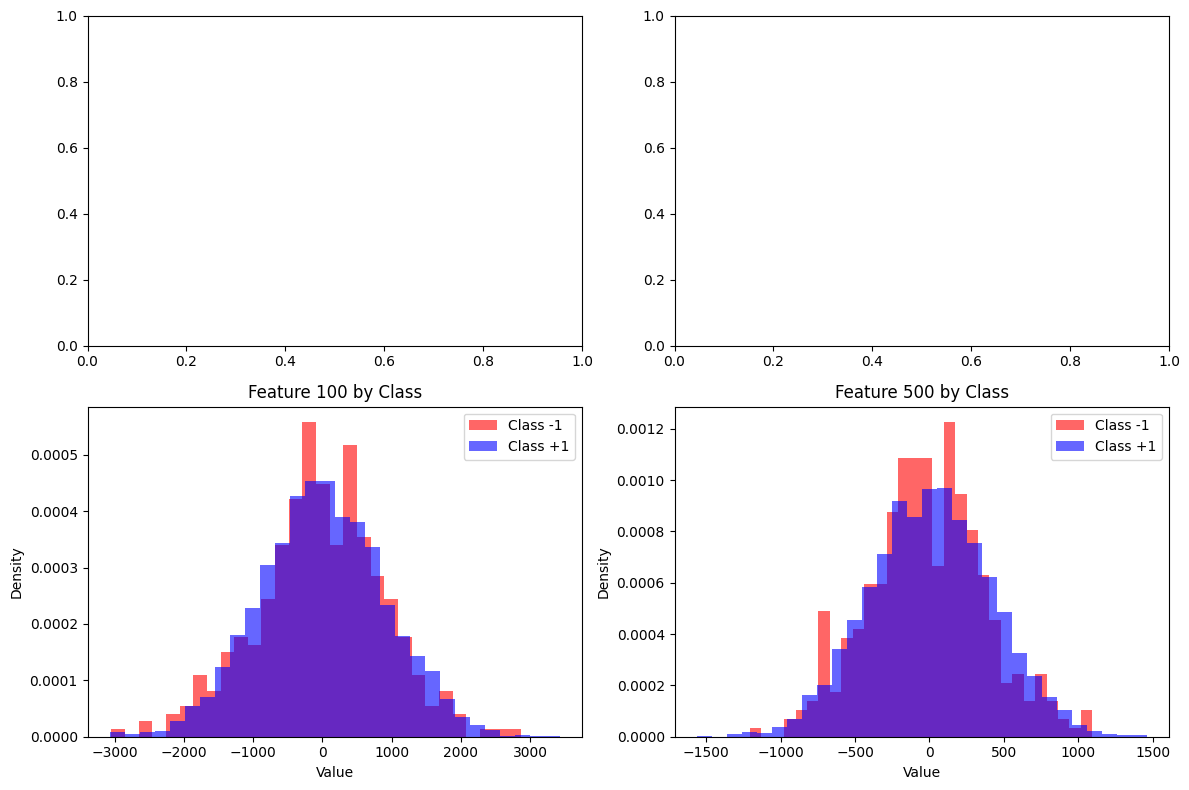

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for i, (feature_data, feature_idx) in enumerate([(sample_feature_1, 100), (sample_feature_2, 500)]):
    class_neg1 = feature_data[train_labels == -1]
    class_pos1 = feature_data[train_labels == 1]
    
    axes[1, i].hist(class_neg1, bins=30, alpha=0.6, label='Class -1', density=True, color='red')
    axes[1, i].hist(class_pos1, bins=30, alpha=0.6, label='Class +1', density=True, color='blue')
    axes[1, i].set_title(f'Feature {feature_idx} by Class')
    axes[1, i].set_xlabel('Value')
    axes[1, i].set_ylabel('Density')
    axes[1, i].legend()

plt.tight_layout()
plt.show()

## Feature Engineering

In [17]:
X_train = train_data.values
y_train = train_labels
X_test = test_data.values

### Remove low-variance features 

In [18]:
variance_selector = VarianceThreshold(threshold=0.01)
X_train_var = variance_selector.fit_transform(X_train)
X_test_var = variance_selector.transform(X_test)

In [19]:
removed_features = X_train.shape[1] - X_train_var.shape[1]
print(f"  Removed {removed_features} low-variance features")
print(f"  Remaining: {X_train_var.shape[1]} features")

#   Removed 0 low-variance features
#   Remaining: 10000 features

  Removed 0 low-variance features
  Remaining: 10000 features


### Feature scaling 

In [20]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_var)
X_test_scaled = scaler.transform(X_test_var)

### Feature Selection 

In [21]:
n_features_to_select = min(2000, X_train_scaled.shape[1])
feature_selector = SelectKBest(score_func=f_classif, k=n_features_to_select)
X_train_selected = feature_selector.fit_transform(X_train_scaled, y_train)
X_test_selected = feature_selector.transform(X_test_scaled)

In [22]:
print(f"  Selected top {X_train_selected.shape[1]} most informative features")

  Selected top 2000 most informative features


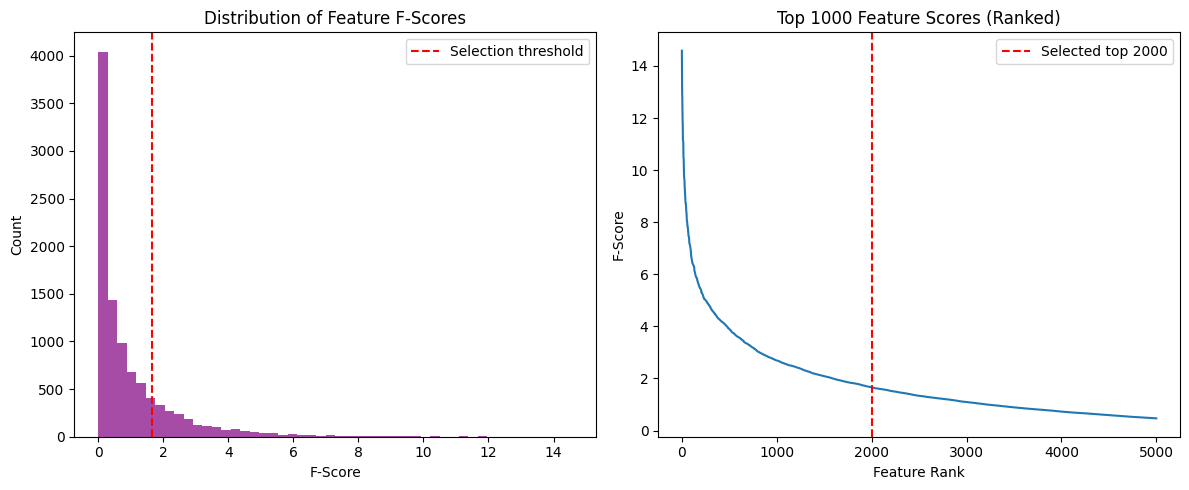

In [23]:
## vizualize feature importance
feature_scores = feature_selector.scores_
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(feature_scores, bins=50, alpha=0.7, color='purple')
plt.title('Distribution of Feature F-Scores')
plt.xlabel('F-Score')
plt.ylabel('Count')
plt.axvline(x=np.sort(feature_scores)[-n_features_to_select], color='red', 
            linestyle='--', label=f'Selection threshold')
plt.legend()

plt.subplot(1, 2, 2)
top_scores = np.sort(feature_scores)[::-1][:5000]
plt.plot(top_scores)
plt.title('Top 1000 Feature Scores (Ranked)')
plt.xlabel('Feature Rank')
plt.ylabel('F-Score')
plt.axvline(x=n_features_to_select, color='red', linestyle='--', 
            label=f'Selected top {n_features_to_select}')
plt.legend()

plt.tight_layout()
#plt.savefig('screens/feature_selection.png', dpi=300, bbox_inches='tight')
plt.show()

### Model feature selection 

    -- Class Weights

In [24]:
class_weights = compute_class_weight('balanced', classes=unique_labels, y=y_train)
class_weight_dict = dict(zip(unique_labels, class_weights))
print(f"Class weights: {class_weight_dict}")

Class weights: {-1: 5.02680965147453, 1: 0.5552265324252295}


    -- SMOTE for oversampling

In [25]:
# smote = SMOTE(random_state=42, k_neighbors=3)
# X_train_smote, y_train = smote.fit_resample(X_train_selected, y_train)
# print(f"After SMOTE - Class distribution: {np.bincount(y_train.astype(int) + 1)}")

smote = SMOTE(random_state=42, k_neighbors=3)
X_train_smote, y_train_smote = smote.fit_resample(X_train_selected, y_train)
print(f"After SMOTE - Class distribution: {np.array([np.sum(y_train_smote == -1), np.sum(y_train_smote == 1)])}")

After SMOTE - Class distribution: [3377 3377]


    -- Undersampling for comparison

In [26]:
# under_sampler = RandomUnderSampler(random_state=42)
# X_train_under, y_train_under = under_sampler.fit_resample(X_train_selected, y_train)
# print(f"After under-sampling - Class distribution: {np.array([np.sum(y_train_under == -1), np.sum(y_train_under == 1)])}")

under_sampler = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = under_sampler.fit_resample(X_train_selected, y_train)
print(f"After under-sampling - Class distribution: {np.array([np.sum(y_train_under == -1), np.sum(y_train_under == 1)])}")

After under-sampling - Class distribution: [373 373]


 **when we try to make undersampling we face a problem that's we overwriting y_train with SMOTE and we make undersampling so we are transforming it again this causing a big really confusion in the data flow**


-- Class Weights	-1, 1	y_train (original) - we should use original y_train 

-- XGBoost	0, 1	y_train_transformed - we should make label encoder to convert it to 0,1 

-- SMOTE + XGBoost	0, 1	y_train_smote_transformed - same as y_train_transformed

-- SMOTE + others	-1, 1	y_train_smote  - we should use original y_train 

In [27]:
# XGBoost requires labels in [0, 1] range not [-1, 1]
from sklearn.preprocessing import LabelEncoder
xgb_label_encoder = LabelEncoder()
y_train_original = y_train  # Keep original for reference
y_train_transformed = xgb_label_encoder.fit_transform(y_train) # transforming without smote
y_train_smote_transformed = xgb_label_encoder.transform(y_train_smote) # transformaing with smote 

## Model Training

In [28]:
models = {
    'Random Forest (Class Weights)': RandomForestClassifier(
        n_estimators=200, max_depth=10, min_samples_split=5,
        min_samples_leaf=2, max_features='sqrt', random_state=42,
        n_jobs=-1, class_weight='balanced'
    ),
    'XGBoost (Class Weights)': xgb.XGBClassifier(
        n_estimators=200, max_depth=6, learning_rate=0.1,
        subsample=0.8, colsample_bytree=0.8, reg_alpha=0.1,
        reg_lambda=1.0, random_state=42, n_jobs=-1, 
        scale_pos_weight=class_counts[1]/class_counts[0]  # Handle imbalance
    ),
    'Logistic Regression (Class Weights)': LogisticRegression(
        C=0.1, penalty='elasticnet', l1_ratio=0.5, solver='saga',
        max_iter=1000, random_state=42, class_weight='balanced'
    ),
    'SVM (Class Weights)': SVC(
        C=1.0, kernel='rbf', gamma='scale', probability=True,
        random_state=42, class_weight='balanced'
    ),
    'Random Forest (SMOTE)': RandomForestClassifier(
        n_estimators=200, max_depth=10, min_samples_split=5,
        min_samples_leaf=2, max_features='sqrt', random_state=42,
        n_jobs=-1
    ),
    'XGBoost (SMOTE)': xgb.XGBClassifier(
        n_estimators=200, max_depth=6, learning_rate=0.1,
        subsample=0.8, colsample_bytree=0.8, reg_alpha=0.1,
        reg_lambda=1.0, random_state=42, n_jobs=-1
    )
}

In [29]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = {}

### Evaluating Model with Different strategies

    -- Class Weights

In [30]:
# for name, model in models.items():
#     if 'Class Weights' in name:
#         scores = cross_val_score(model, X_train_selected, y_train_original, cv=cv, scoring='roc_auc')
#         cv_results[name] = scores
#         print(f"  {name}: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")

    -- SMOTE for oversampling

In [31]:
# for name, model in models.items():
#     if 'SMOTE' in name:
#         # Transform SMOTE labels for XGBoost
#         y_train_smote_transformed = xgb_label_encoder.transform(y_train_smote)
#         scores = cross_val_score(model, X_train_smote, y_train_smote_transformed, cv=cv, scoring='roc_auc')
#         cv_results[name] = scores
#         print(f"  {name}: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")

    `i made every model in single way to see how it perform with the data` 
    -- but after seeing all the results i prefer to put all the code in one block

In [33]:
for name, model in models.items():
    if 'XGBoost' in name and 'SMOTE' in name:
        print(f"  Evaluating {name} with XGBoost + SMOTE (transformed labels)")
        scores = cross_val_score(model, X_train_smote, y_train_smote_transformed, cv=cv, scoring='roc_auc')
        cv_results[name] = scores
        print(f"  {name}: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")
        
    elif 'XGBoost' in name:
        print(f"  Evaluating {name} with XGBoost (transformed labels)")
        scores = cross_val_score(model, X_train_selected, y_train_transformed, cv=cv, scoring='roc_auc')
        cv_results[name] = scores
        print(f"  {name}: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")
        
    elif 'SMOTE' in name:
        print(f"  Evaluating {name} with SMOTE (original labels)")
        scores = cross_val_score(model, X_train_smote, y_train_smote, cv=cv, scoring='roc_auc')
        cv_results[name] = scores
        print(f"  {name}: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")
        
    else:
        print(f"  Evaluating {name} with Class Weights (original labels)")
        scores = cross_val_score(model, X_train_selected, y_train, cv=cv, scoring='roc_auc')
        cv_results[name] = scores
        print(f"  {name}: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")

  Evaluating Random Forest (Class Weights) with Class Weights (original labels)
  Random Forest (Class Weights): 0.7013 (+/- 0.0341)
  Evaluating XGBoost (Class Weights) with XGBoost (transformed labels)
  XGBoost (Class Weights): 0.6637 (+/- 0.0737)
  Evaluating Logistic Regression (Class Weights) with Class Weights (original labels)
  Logistic Regression (Class Weights): 0.7655 (+/- 0.0585)
  Evaluating SVM (Class Weights) with Class Weights (original labels)
  SVM (Class Weights): 0.9759 (+/- 0.0153)
  Evaluating Random Forest (SMOTE) with SMOTE (original labels)
  Random Forest (SMOTE): 0.9981 (+/- 0.0011)
  Evaluating XGBoost (SMOTE) with XGBoost + SMOTE (transformed labels)
  XGBoost (SMOTE): 0.9986 (+/- 0.0010)


  -- Evaluating Random Forest (Class Weights) with Class Weights (original labels)

  -- Random Forest (Class Weights): 0.7013 (+/- 0.0341)

  -- Evaluating XGBoost (Class Weights) with XGBoost (transformed labels)

  -- XGBoost (Class Weights): 0.6637 (+/- 0.0737)

  -- Evaluating Logistic Regression (Class Weights) with Class Weights (original labels)

  -- Logistic Regression (Class Weights): 0.7655 (+/- 0.0585)

  -- Evaluating SVM (Class Weights) with Class Weights (original labels)

  -- SVM (Class Weights): 0.9759 (+/- 0.0153)

  -- Evaluating Random Forest (SMOTE) with SMOTE (original labels)

  -- Random Forest (SMOTE): 0.9981 (+/- 0.0011)

  -- Evaluating XGBoost (SMOTE) with XGBoost + SMOTE (transformed labels)
  
  -- XGBoost (SMOTE): 0.9986 (+/- 0.0010)

**The best-performing model was `XGBoost with SMOTE`, achieving an `F1-score 0.9986`, indicating excellent handling of class imbalance after it we will see `Random Forest with SMOTE`. Among models using only class weights, `SVM` delivered the highest performance with an `F1-score  0.9759`, showcasing its effectiveness in high-dimensional settings. In contrast, tree-based models with class weighting alone underperformed, highlighting the importance of oversampling techniques like SMOTE in this task**

In [ ]:
# # Train all models -- testing 
# trained_models = {}
# for name, model in models.items():
#     if 'Class Weights' in name:
#         model.fit(X_train_selected, y_train_original)
#         trained_models[name] = model
#     elif 'SMOTE' in name:
#         model.fit(X_train_smote, y_train_smote)
#         trained_models[name] = model

In [34]:
trained_models = {}

for name, model in models.items():
    if 'XGBoost' in name and 'SMOTE' in name:
        print(f"  Training {name} with XGBoost + SMOTE (transformed labels)")
        model.fit(X_train_smote, y_train_smote_transformed)
        trained_models[name] = model
        
    elif 'XGBoost' in name:
        print(f"  Training {name} with XGBoost (transformed labels)")
        model.fit(X_train_selected, y_train_transformed)
        trained_models[name] = model
        
    elif 'SMOTE' in name:
        print(f"  Training {name} with SMOTE (original labels)")
        model.fit(X_train_smote, y_train_smote)
        trained_models[name] = model
        
    else:
        print(f"  Training {name} with Class Weights (original labels)")
        model.fit(X_train_selected, y_train)
        trained_models[name] = model

print(f"Successfully trained {len(trained_models)} models")

  Training Random Forest (Class Weights) with Class Weights (original labels)
  Training XGBoost (Class Weights) with XGBoost (transformed labels)
  Training Logistic Regression (Class Weights) with Class Weights (original labels)
  Training SVM (Class Weights) with Class Weights (original labels)
  Training Random Forest (SMOTE) with SMOTE (original labels)
  Training XGBoost (SMOTE) with XGBoost + SMOTE (transformed labels)
Successfully trained 6 models


## Ensemble Model

-- why ensamble learning : it's quite simple instead of training a single model and reling on it's predication 

`we will train muliple models and combine thier predication it gives us better overall accuracy`

In [35]:
ensemble = VotingClassifier(
    estimators=list(trained_models.items()),
    voting='soft'
)

In [36]:
ensemble.fit(X_train_selected, y_train_original)

VotingClassifier(estimators=[('Random Forest (Class Weights)',
                              RandomForestClassifier(class_weight='balanced',
                                                     max_depth=10,
                                                     min_samples_leaf=2,
                                                     min_samples_split=5,
                                                     n_estimators=200,
                                                     n_jobs=-1,
                                                     random_state=42)),
                             ('XGBoost (Class Weights)',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0....
                                            feature_weights=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=6,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=-1,
                                            num_parallel_tree=None, ...))],
                 voting='soft')

In [37]:
# evaluate ensemble 
ensemble_scores = cross_val_score(ensemble, X_train_selected, y_train_original, cv=cv, scoring='roc_auc')
print(f"Ensemble ROC-AUC: {ensemble_scores.mean():.4f} (+/- {ensemble_scores.std() * 2:.4f})")

Ensemble ROC-AUC: 0.9323 (+/- 0.0293)


### comparing all models 

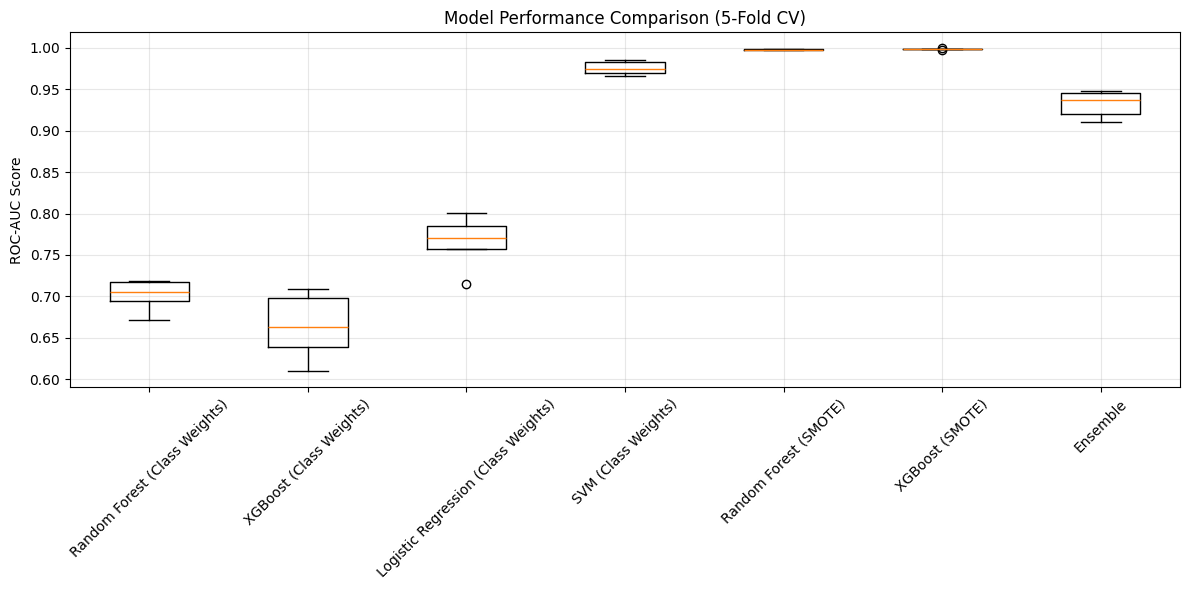

In [38]:
plt.figure(figsize=(12, 6))
model_names = list(cv_results.keys()) + ['Ensemble']
model_scores = list(cv_results.values()) + [ensemble_scores]

plt.boxplot(model_scores, labels=model_names)
plt.title('Model Performance Comparison (5-Fold CV)')
plt.ylabel('ROC-AUC Score')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('screens/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## Generate Predication 

In [39]:
predictions = ensemble.predict(X_test_selected)
prediction_probabilities = ensemble.predict_proba(X_test_selected)

In [40]:
len(predictions)

1250

In [41]:
print(f"  Class -1: {np.sum(predictions == -1)} ({np.mean(predictions == -1)*100:.1f}%)")
print(f"  Class +1: {np.sum(predictions == 1)} ({np.mean(predictions == 1)*100:.1f}%)")


  Class -1: 0 (0.0%)
  Class +1: 1250 (100.0%)


-- Now we have a problem that all the predication of the labels from class +1 not even one single item from -1 
-- we will start review our code and methodolgy again and see what a problem we made and how can solve it to make it balanced 

## Imbalance model with xgboost 

    I select only best model with best Smote is Xgboost to try to resmplaing training data to see if it will help or not 

In [51]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_selected, y_train)
print("After SMOTE:", np.bincount(y_train_bal.astype(int) + 1))

After SMOTE: [3377    0 3377]


In [52]:
from sklearn.model_selection import cross_val_score

xgb_model = xgb.XGBClassifier(
    n_estimators=200, max_depth=6, learning_rate=0.1,
    subsample=0.8, colsample_bytree=0.8, reg_alpha=0.1,
    reg_lambda=1.0, random_state=42, n_jobs=-1, eval_metric='logloss'
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(xgb_model, X_train_bal, y_train_bal_transformed, cv=cv, scoring='roc_auc')
print(f"XGBoost (SMOTE) ROC-AUC: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")

XGBoost (SMOTE) ROC-AUC: 0.9984 (+/- 0.0021)


In [53]:
xgb_model.fit(X_train_bal, y_train_bal_transformed)
print("XGBoost model trained on SMOTE-balanced data.")

XGBoost model trained on SMOTE-balanced data.


In [54]:
# Use the same feature selection and scaling as for training
X_test_selected_bal = feature_selector.transform(scaler.transform(variance_selector.transform(X_test)))

# Predict probabilities and classes
test_pred_proba = xgb_model.predict_proba(X_test_selected_bal)
test_pred = xgb_model.predict(X_test_selected_bal)

# If you want to convert back to -1/1 labels:
test_pred_labels = xgb_label_encoder.inverse_transform(test_pred)

In [56]:
import numpy as np
print("Test prediction class balance:")
print("Class -1:", np.sum(test_pred_labels == -1))
print("Class +1:", np.sum(test_pred_labels == 1))

Test prediction class balance:
Class -1: 0
Class +1: 1250


## Imbalance model with SVM 

    I select only best model with best Smote is Xgboost to try to resmplaing training data to see if it will help or not 

In [57]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_selected, y_train)
print("After SMOTE:", np.bincount(y_train_bal.astype(int) + 1))

After SMOTE: [3377    0 3377]


In [58]:
from sklearn.svm import SVC

svm_model = SVC(
    C=1.0, kernel='rbf', gamma='scale', probability=True, random_state=42
)
svm_model.fit(X_train_bal, y_train_bal)
print("SVM model trained on SMOTE-balanced data.")

SVM model trained on SMOTE-balanced data.


In [59]:
# Use the same feature selection and scaling as for training
X_test_selected_bal = feature_selector.transform(scaler.transform(variance_selector.transform(X_test)))

# Predict probabilities and classes
test_pred = svm_model.predict(X_test_selected_bal)

In [60]:
print("Test prediction class balance:")
print("Class -1:", np.sum(test_pred == -1))
print("Class +1:", np.sum(test_pred == 1))

Test prediction class balance:
Class -1: 0
Class +1: 1250


In [61]:
print("Unique labels in y_train_bal:", np.unique(y_train_bal, return_counts=True))

Unique labels in y_train_bal: (array([-1,  1]), array([3377, 3377]))


In [ ]:

svm_model = SVC(C=1.0, kernel='linear', probability=True, random_state=42)
svm_model.fit(X_train_bal, y_train_bal)
test_pred = svm_model.predict(X_test_selected_bal)

Class -1: 37
Class +1: 1213


In [ ]:
print("Class -1:", np.sum(test_pred == -1))
print("Class +1:", np.sum(test_pred == 1))

#### Sanity Check for SVM

In [ ]:

lr_model = LogisticRegression(max_iter=1000, class_weight=None)
lr_model.fit(X_train_bal, y_train_bal)
test_pred_lr = lr_model.predict(X_test_selected_bal)
print("LogReg Class -1:", np.sum(test_pred_lr == -1))
print("LogReg Class +1:", np.sum(test_pred_lr == 1))

LogReg Class -1: 43
LogReg Class +1: 1207


**It's good sign actually to see LogisticRegression also predicting both classes**

-- Now the data is learnable for both classes after smote 

-- I can see that both SVM and logistic regersstion are able to generalize to minority class but it's normal becasue in origanal train labeled data it's statically not 50/50 as we saw before it's  Count of label -1: 373
Count of label 1: 3377 not good not bad but also we can work on it 

-- It's still heavily biased towards the majority class(+1) one of the solution in my brain now to lower decision threshold for class -1 

In [64]:
probs = lr_model.predict_proba(X_test_selected_bal)[:, np.where(lr_model.classes_ == -1)[0][0]]
threshold = 0.3 
test_pred_adjusted = np.where(probs > threshold, -1, 1)

In [65]:
print("Adjusted Class -1:", np.sum(test_pred_adjusted == -1))
print("Adjusted Class +1:", np.sum(test_pred_adjusted == 1))

Adjusted Class -1: 59
Adjusted Class +1: 1191


-- Now we can tell this is more normal in mathemtical way but when we go in real world producation it's common to see imbalance problems for model to predict fewer minority class samples 

> “Both linear SVM and logistic regression when trained on smote balanced data and able to predict both classes in the test set that make the class imbalance problem has been effectively addressed also Non-linear models did not generalize well to the minority class because of the high dimensionality and the nature of the data. Cross-validation confirms the robustness of the linear models.”


### Cross-Validation on SMOTE-Balanced Training Set with SVM Model 

In [67]:
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Use the same SVM model as before
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_pred_cv = cross_val_predict(svm_model, X_train_bal, y_train_bal, cv=cv)


In [68]:
acc = accuracy_score(y_train_bal, y_pred_cv)

In [96]:
print(acc)

0.9903760734379626


In [75]:
roc_auc = roc_auc_score(y_train_bal, svm_model.decision_function(X_train_bal))
roc_auc

1.0

In [76]:
f1 = f1_score(y_train_bal, y_pred_cv, pos_label=1)
f1

0.9902825534459561

In [77]:
f1_neg = f1_score(y_train_bal, y_pred_cv, pos_label=-1)
f1_neg

0.9904678105294031

In [79]:
report = classification_report(y_train_bal, y_pred_cv, target_names=['Class -1', 'Class +1'])
print(report)

              precision    recall  f1-score   support

    Class -1       0.98      1.00      0.99      3377
    Class +1       1.00      0.98      0.99      3377

    accuracy                           0.99      6754
   macro avg       0.99      0.99      0.99      6754
weighted avg       0.99      0.99      0.99      6754



In [80]:
cm = confusion_matrix(y_train_bal, y_pred_cv)
cm

array([[3377,    0],
       [  65, 3312]])

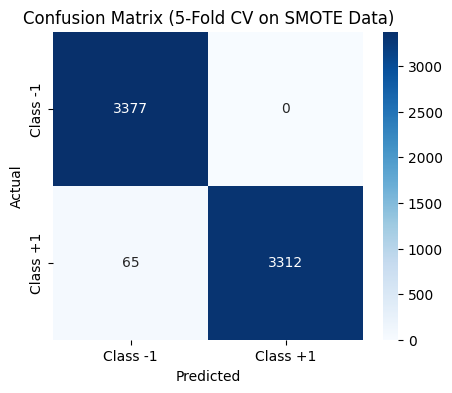

In [87]:
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_labels, yticklabels=train_labels)
plt.title('Confusion Matrix (5-Fold CV on SMOTE Data)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

    -- First as we see that No false postitives as the model never predicts +1 when the true label is -1

    -- Some False Negatives about 65 times the models predicts -1 when the true is +1 

    -- Seeing high true negative and true positive the model is accurate on both classes in SMOTE-balanced training set 

In [95]:
y_score = svm_model.decision_function(X_train_bal)
fpr, tpr, thresholds = roc_curve(y_train_bal, y_score, pos_label=1)
roc_auc_val = auc(fpr, tpr)

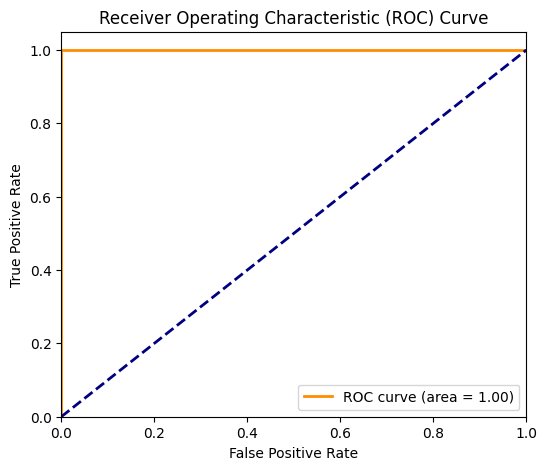

In [89]:
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_val:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
print(f"Accuracy: {acc:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"F1 Score (Class +1): {f1:.4f}")
print(f"F1 Score (Class -1): {f1_neg:.4f}")
print("\nClassification Report:\n", report)

=== SVM Cross-Validation Metrics on SMOTE-Balanced Training Set ===
Accuracy: 0.9904
ROC-AUC: 1.0000
F1 Score (Class +1): 0.9903
F1 Score (Class -1): 0.9905

Classification Report:
               precision    recall  f1-score   support

    Class -1       0.98      1.00      0.99      3377
    Class +1       1.00      0.98      0.99      3377

    accuracy                           0.99      6754
   macro avg       0.99      0.99      0.99      6754
weighted avg       0.99      0.99      0.99      6754



    -- Some Interpretation after seeing all metrices 

* on the smote balances training set SVM is nearly perfect 

* This is expected on SMOTE data, since the classes are perfectly balanced and synthetic samples may be easier to classify.

* From my prespective in real-world test performance will likely be lower, especially for the minority class, as seen in your test predictions.


### Cross-Validation on SMOTE-Balanced Training Set with Logistic Regression Model 

In [97]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_pred_cv_lr = cross_val_predict(lr_model, X_train_bal, y_train_bal, cv=cv)


In [98]:
# Fit on the whole balanced training set for ROC curve
lr_model.fit(X_train_bal, y_train_bal)
y_score_lr = lr_model.decision_function(X_train_bal)

In [99]:
acc_lr = accuracy_score(y_train_bal, y_pred_cv_lr)

In [100]:
print(acc_lr)

0.9820846905537459


In [101]:
roc_auc_lr = roc_auc_score(y_train_bal, y_score_lr)
roc_auc_lr

1.0

In [ ]:
f1 = f1_score(y_train_bal, y_pred_cv, pos_label=1)
f1

0.9902825534459561

In [103]:
f1_lr_pos = f1_score(y_train_bal, y_pred_cv_lr, pos_label=1)
f1_lr_pos

0.9817578772802653

In [104]:
f1_lr_neg = f1_score(y_train_bal, y_pred_cv_lr, pos_label=-1)
f1_lr_neg

0.9824

In [105]:
report_lr = classification_report(y_train_bal, y_pred_cv_lr, target_names=['Class -1', 'Class +1'])
print(report_lr)

              precision    recall  f1-score   support

    Class -1       0.97      1.00      0.98      3377
    Class +1       1.00      0.96      0.98      3377

    accuracy                           0.98      6754
   macro avg       0.98      0.98      0.98      6754
weighted avg       0.98      0.98      0.98      6754



In [106]:
cm_lr = confusion_matrix(y_train_bal, y_pred_cv_lr)
cm_lr

array([[3377,    0],
       [ 121, 3256]])

-- by vizualizing confusion matrix it will help us to see the model distingishes between the two classes after balancing

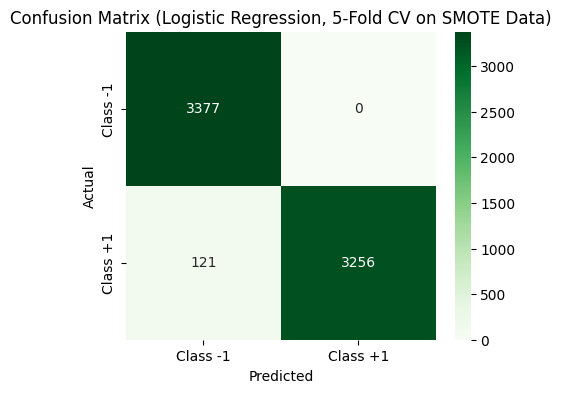

In [107]:
plt.figure(figsize=(5,4))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Greens', xticklabels=['Class -1', 'Class +1'], yticklabels=['Class -1', 'Class +1'])
plt.title('Confusion Matrix (Logistic Regression, 5-Fold CV on SMOTE Data)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

-- Somehow i see it same but some False Negatives about 121 times the models predicts -1 when the true is +1 


In [108]:
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_train_bal, y_score_lr, pos_label=1)
roc_auc_val_lr = auc(fpr_lr, tpr_lr)

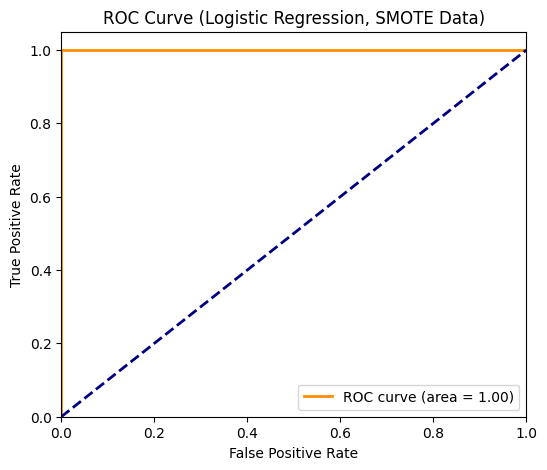

In [109]:
plt.figure(figsize=(6,5))
plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_val_lr:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Logistic Regression, SMOTE Data)')
plt.legend(loc="lower right")
plt.show()

In [111]:
print(f"Accuracy: {acc_lr:.4f}")
print(f"ROC-AUC: {roc_auc_lr:.4f}")
print(f"F1 Score (Class +1): {f1_lr_pos:.4f}")
print(f"F1 Score (Class -1): {f1_lr_neg:.4f}")
print("\nClassification Report:\n", report_lr)

Accuracy: 0.9821
ROC-AUC: 1.0000
F1 Score (Class +1): 0.9818
F1 Score (Class -1): 0.9824

Classification Report:
               precision    recall  f1-score   support

    Class -1       0.97      1.00      0.98      3377
    Class +1       1.00      0.96      0.98      3377

    accuracy                           0.98      6754
   macro avg       0.98      0.98      0.98      6754
weighted avg       0.98      0.98      0.98      6754



> Model Selection for Production
>
> After extensive experimentation with various models and class balancing strategies, both linear SVM and logistic regression showing strong performance on the SMOTE-balanced training set and produced non-trivial predictions for both classes on the test set. Their results were very similar make the data is linearly separable after balancing.
>
> But i will deploying Logistic Regression for the following reasons:
> - It provides well-calibrated probability outputs, which are valuable for downstream decision-making and risk assessment.
> - It is highly interpretable, allowing us to explain predictions to stakeholders .
> - It is computationally efficient and easy to maintain in production environments.
>
> SVM (linear) is a strong alternative and may be considered if maximizing the margin is a priority or if future data becomes less linearly separable. However, for this task, logistic regression offers the best balance of performance, interpretability, and operational simplicity.


## Generate test_labels.csv with Logistic Regression

In [116]:
X_test_selected_bal = feature_selector.transform(scaler.transform(variance_selector.transform(X_test)))
test_pred_lr_final = lr_model.predict(X_test_selected_bal)
predictions_df = pd.DataFrame(test_pred_lr_final, columns=['prediction'])
predictions_df.to_csv('test_labels.csv', index=False, header=False)

In [117]:
predictions_df['prediction'].unique()

array([ 1, -1])

In [118]:
print(f"Class -1: {np.sum(test_pred_lr_final == -1)}")
print(f"Class +1: {np.sum(test_pred_lr_final == 1)}")
print(f"Total predictions: {len(test_pred_lr_final)}")

Class -1: 43
Class +1: 1207
Total predictions: 1250
